# COVID-19 Detection in Chest X-Ray Images
The goal of this project is to develop a machine learning model that can classify chest X-ray images into three categories: COVID-19, Normal, and Pneumonia. The dataset, sourced from Mendeley, contains 606 images across these three classes. This notebook involves data preprocessing, Roboflow-assisted image cleaning, feature extraction (both pixel and texture-based), and classification using multiple ML models.

In [1]:
import os
import time
import zipfile
from glob import glob
import cv2 as cv
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import requests
from dotenv import load_dotenv
from roboflow import Roboflow
from skimage import io
from skimage.feature import graycomatrix, graycoprops
from skimage.transform import resize
from sklearn.metrics import classification_report, ConfusionMatrixDisplay, roc_auc_score
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.preprocessing import StandardScaler
from scipy.stats import randint, uniform

### Set Constants
In this section, we load the necessary API keys (in this case, the Roboflow API key) from a .env file using the dotenv package. We also set a constant for random state, so that the analysis is reproducable.

In [2]:
load_dotenv()
ROBOFLOW_KEY = os.getenv("ROBOFLOW_API_KEY")

RANDOM_STATE = 42

## Download and Unzip Images
This step checks whether the dataset exists locally. If not, it downloads and unzips the dataset into a structured directory format. During extraction, file and folder names are sanitized for consistency.

In [3]:
dataroot = "dataroot/"
zip_path = dataroot + "fvk7h5dg2p-1.zip"
raw_path = dataroot + "raw/"

def download_data(url):
    '''
    Creates a directory nammed 'dataroot' and downloads the zip file from the url and saves the zip file
    to the 'dataroot' folder.
    '''
    response = requests.get(url, params={"downloadformat": "zip"})
    if not os.path.isdir(dataroot):
        os.makedirs(dataroot)
        with open(zip_path, "wb") as file:
            file.write(response.content)


def unzip_data():
    if os.path.isdir(dataroot):
        with zipfile.ZipFile(zip_path, "r") as zip_ref:
            for file in zip_ref.namelist():
                sanitized_name = file.strip().replace("\\", "/") #Ensure consistent path format
                #Sanitize folder name for "Normal "
                if sanitized_name.startswith("Normal "):
                    sanitized_name = sanitized_name.replace("Normal ", "Normal", 1)
                if sanitized_name.startswith("COVID-19"):
                    sanitized_name = sanitized_name.replace("COVID-19 cases", "COVID-19", 1)
            
                #Create the full target path within the 'Normal' folder
                target_path = os.path.join(raw_path, sanitized_name)

                #Skip directories (avoid trying to open them as files)
                if file.endswith("/"):
                    os.makedirs(target_path, exist_ok=True)
                    continue
            
                #Ensure the parent directory exists before extracting
                os.makedirs(os.path.dirname(target_path), exist_ok=True)

                # Extract file safely
                with zip_ref.open(file) as source, open(target_path, "wb") as target:
                    target.write(source.read())

        os.remove(zip_path) # Remove zip file
        print("Extraction completed successfully.")

In [4]:
# Download and unzip
if not os.path.isdir(dataroot):
    download_data("https://prod-dcd-datasets-cache-zipfiles.s3.eu-west-1.amazonaws.com/fvk7h5dg2p-1.zip")
    unzip_data()
else:
    print("dataroot already exists.")

dataroot already exists.


## Cleaning with Roboflow
We connect to a Roboflow object detection model to preprocess the dataset. This involves resizing each image and zeroing out regions identified by Roboflow as irrelevant or noisy, thus enhancing the signal for classification.

In [5]:
#Connecting to the model on roboflow
rf = Roboflow(api_key=ROBOFLOW_KEY)
project = rf.workspace().project("cap-project-u384k")
model = project.version(1).model

loading Roboflow workspace...
loading Roboflow project...


### Image Cleaning Strategy
Images are resized to a uniform resolution to meet Roboflow API constraints. A retry mechanism is implemented for API robustness, and predictions are used to black out detected regions in the images.

In [6]:
def safe_predict(model, img, retries=3):
    """Function for performing roboflow predict multiple times
    when needed due to API constrictions"""
    for attempt in range(retries):
        try:
            return model.predict(img, confidence=20, overlap=30).json()
        except requests.exceptions.ConnectionError as e:
            print(f"Connection error on attempt {attempt + 1}: {e}")
            time.sleep(2 ** attempt)  # exponential backoff
    raise RuntimeError("Max retries exceeded for model prediction.")

def clean_x_rays(input_folder, output_folder):
    os.makedirs(output_folder, exist_ok=True)
    for item in os.walk(input_folder):
        root = item[0]
        files = item[2]
        for file in files:
            if not os.path.exists(os.path.join(output_folder, file)): # Skip over already processed files
                time.sleep(3)
                img = cv.imread(os.path.join(root, file))
                img = resize(img, (512, 512), anti_aliasing=True, preserve_range=True).astype(np.uint8)
                result = safe_predict(model, img)
                for i in range(len(result['predictions'])):
                    prediction = result['predictions'][i]
                    roi_x = int(prediction['x'] - prediction['width']/2)
                    roi_y = int(prediction['y'] - prediction['height']/2)
                    roi_width = int(prediction['width'])
                    roi_height = int(prediction['height'])
                    img[roi_y:roi_y+roi_height, roi_x:roi_x+roi_width] = 0
                cv.imwrite(os.path.join(output_folder, file), img)

### Process All Images if Not Already Cleaned
This step checks if the cleaned folders exist. If not, it processes all raw images using the cleaning logic described above, skipping over any files already cleaned.

In [7]:
raw_path = "dataroot/raw/"
clean_path = "dataroot/cleaned/"
if not all([os.path.isdir(clean_path + "COVID-19"),
            os.path.isdir(clean_path + "Normal"),
            os.path.isdir(clean_path + "Pneumonia")]):
    clean_x_rays(raw_path + "COVID-19", clean_path + "COVID-19")
    print("COVID-19 Images Processed")
    clean_x_rays(raw_path + "Normal", clean_path + "Normal")
    print("Normal Images Processed")
    clean_x_rays(raw_path + "Pneumonia", clean_path + "Pneumonia")
    print("Pneumonia Images Processed")

### View Raw Images
Here we visualize sample images from the raw dataset across all three classes to understand the visual structure and differences among them.

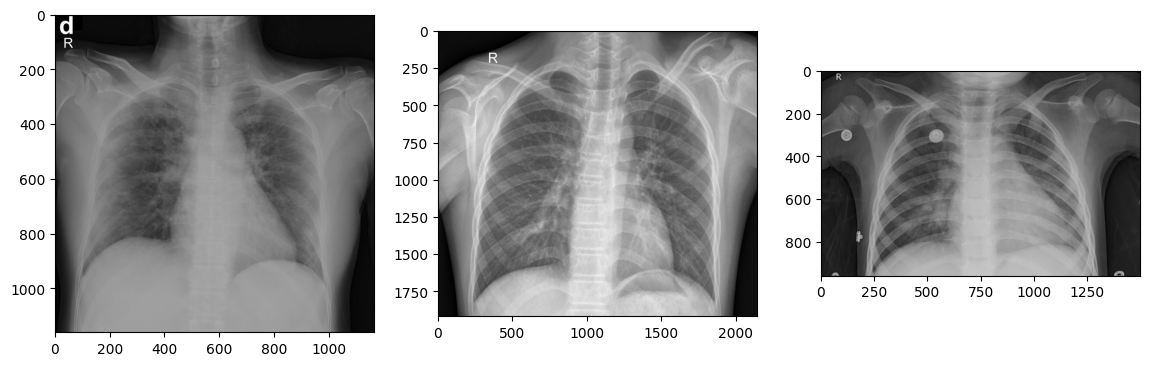

In [8]:
# Load and preview raw images
raw_img_covid     = cv.imread(raw_path + 'COVID-19/1-s2.0-S0929664620300449-gr2_lrg-d.jpg', 0)
raw_img_normal    = cv.imread(raw_path + 'Normal/IM-0011-0001-0001.jpeg', 0)
raw_img_pneumonia = cv.imread(raw_path + 'Pneumonia/person11_virus_38.jpeg', 0)

plt.figure(figsize=(14,14))
plt.subplot(1,3,1)
plt.imshow(raw_img_covid,cmap='gray')
plt.subplot(1,3,2)
plt.imshow(raw_img_normal,cmap='gray')
plt.subplot(1,3,3)
plt.imshow(raw_img_pneumonia,cmap='gray')

### View Cleaned Images
This section provides a side-by-side view of cleaned images to compare the effectiveness of the Roboflow cleaning process.

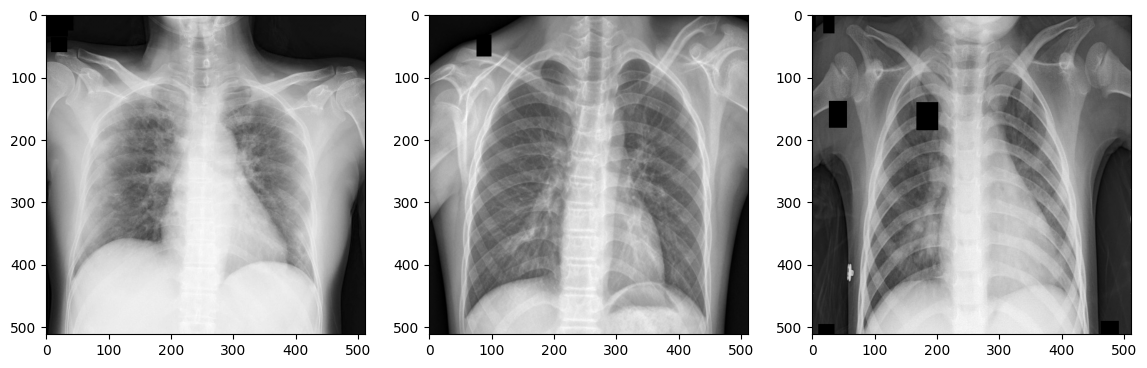

In [9]:

# Load and preview raw images
clean_img_covid     = cv.imread(clean_path + 'COVID-19/1-s2.0-S0929664620300449-gr2_lrg-d.jpg', 0)
clean_img_normal    = cv.imread(clean_path + 'Normal/IM-0011-0001-0001.jpeg', 0)
clean_img_pneumonia = cv.imread(clean_path + 'Pneumonia/person11_virus_38.jpeg', 0)

plt.figure(figsize=(14,14))
plt.subplot(2,3,1)
plt.imshow(clean_img_covid,cmap='gray')
plt.subplot(2,3,2)
plt.imshow(clean_img_normal,cmap='gray')
plt.subplot(2,3,3)
plt.imshow(clean_img_pneumonia,cmap='gray')

# Images and Their Corresponding Labels
We load all cleaned images, assign them class labels based on their directory, and return the images along with metadata. This is crucial for downstream machine learning tasks.

In [10]:
def load_chest_xray_data(data_dir):
    """
    Load chest X-ray images from a directory with subfolders for each class.
    
    Parameters:
    -----------
    data_dir : str
        Path to the main directory containing subfolders with images
    
    Returns:
    --------
    images : list
        List of image arrays
    labels : list
        List of corresponding labels
    label_map : dict
        Dictionary mapping label indices to label names
    image_paths : list
        List of image file paths
    """
    # Get all subdirectories (class labels)
    subfolders = [f for f in os.listdir(data_dir) if os.path.isdir(os.path.join(data_dir, f))]
    
    # Create a label mapping
    label_map = {i: label for i, label in enumerate(subfolders)}
    
    images = []
    labels = []
    image_paths = []
    
    print(f"Found {len(subfolders)} classes: {subfolders}")
    
    # Loop through each subfolder (class)
    for label_idx, subfolder in enumerate(subfolders):
        class_dir = os.path.join(data_dir, subfolder)
        print(f"Loading images from {subfolder}...")
        
        # Get all image files
        img_paths = []
        for ext in ['*.png', '*.jpg', '*.jpeg']:
            img_paths.extend(glob(os.path.join(class_dir, ext)))
        
        # Load each image
        for img_path in img_paths:
            try:
                # Read image and convert to grayscale
                img = io.imread(img_path)
                if len(img.shape) > 2:  # Check if the image has more than 2 dimensions
                    img = np.mean(img, axis=2).astype(np.uint8)  # Convert to grayscale
                
                images.append(img)
                labels.append(label_idx)
                image_paths.append(img_path)
                
            except Exception as e:
                print(f"Error loading {img_path}: {e}")
        
        print(f"Loaded {len(img_paths)} images from {subfolder}")
    
    print(f"Total loaded: {len(images)} images")
    
    return images, labels, label_map, image_paths

In [11]:
images, labels, label_map, image_paths = load_chest_xray_data(clean_path)

Found 3 classes: ['COVID-19', 'Normal', 'Pneumonia']
Loading images from COVID-19...
Loaded 221 images from COVID-19
Loading images from Normal...
Loaded 234 images from Normal
Loading images from Pneumonia...
Loaded 148 images from Pneumonia
Total loaded: 603 images


Function for getting the analytics output for the model based on the mode, and test data.

In [12]:
from sklearn.preprocessing import OneHotEncoder
from IPython.display import display
import ipywidgets as widgets
import re

def get_model_analytics(model, x_test, y_test):
    # Make predictions
    y_pred = model.predict(X=x_test)
    
    # For SVM, ensure 'probability=True' to get predict_proba
    if hasattr(model, "predict_proba"):
        y_prob = model.predict_proba(X=x_test)
    else:
        # If no predict_proba, use decision function (for SVM)
        y_prob = model.decision_function(X=x_test)
        # For multi-class classification, we need to convert decision_function to probabilities
        encoder = OneHotEncoder()
        y_prob = encoder.fit_transform(y_prob.reshape(-1, 1)).toarray()

    # Split model class name and print all caps for section title
    if model.__class__.__name__ == "SVC":
        print(f"{model.__class__.__name__} MODEL ANALYTICS")
        print("-" * 50)
    else:
        model_name = re.split(r'(?=[A-Z])', model.__class__.__name__)
        model_name = ' '.join(filter(None, model_name))
        print(f"{model_name.upper()} MODEL ANALYTICS")
        print("-" * 50)

    # Print per-class AUC scores
    print(f"ROC-AUC Scores with OVR:\n{'ROC-AUC':>23}\n")
    for cls, score in zip(list(label_map.values()),
                          roc_auc_score(y_true=y_test, 
                                        y_score=y_prob, 
                                        multi_class='ovr', 
                                        average=None)):
        print(f"{cls:>12} {score:>10.4f}")

    # Print macro average AUC
    macro_auc = roc_auc_score(y_true=y_test, 
                          y_score=y_prob, 
                          multi_class='ovr', 
                          average='macro')
    print(f"\n{'macro avg':>12} {macro_auc:>10.4f}")

    # classification report
    print("\n\nClassification Report:")
    print(classification_report(y_true=y_test,
                                y_pred=y_pred,
                                target_names=list(label_map.values()),
                                digits=4))
        
    # Confustion matrix
    ConfusionMatrixDisplay.from_predictions(y_true=y_test,
                                            y_pred=y_pred,
                                            display_labels=label_map.values(),
                                            cmap=plt.cm.Blues,
                                            colorbar=False)
    plt.title("Confusion Matrix")
    plt.show()

def run_model_analytics_in_column(model, x_test, y_test, col_list):
    out = widgets.Output()
    with out:
        get_model_analytics(model, x_test, y_test)
    col_list.append(out)

def show_model_analytics_columns(col_list, columns_per_row=4, border_style="1px solid black", border_radius="8px", padding="10px"):
    rows = []
    for i in range(0, len(col_list), columns_per_row):
        children = []
        for out in col_list[i:i+columns_per_row]:
            # Each output wrapped in a Box with a border
            child = widgets.Box(
                [out],
                layout=widgets.Layout(
                    border=border_style,
                    border_radius=border_radius,
                    padding=padding,
                    margin=f"10px 10px",  # spacing between columns
                    width='100%',  # Let it stretch inside the row
                )
            )
            children.append(child)
        row = widgets.HBox(children, layout=widgets.Layout(align_items='flex-start'))
        rows.append(row)
    display(widgets.VBox(rows))

# Flattened Images Section
Images are flattened into 1D arrays to serve as features for machine learning models. Labels are preserved, and a train-test split is applied. Feature scaling is done using StandardScaler.

In [37]:
df = pd.DataFrame({
    "image": [img.flatten() for img in images],
    "label": labels})

X_train_flat, X_test_flat, y_train_flat, y_test_flat = train_test_split(
    np.array(df["image"].tolist()), 
    df["label"], 
    test_size=0.2, 
    stratify=labels, 
    random_state=RANDOM_STATE)

X_train_flat = StandardScaler().fit_transform(X_train_flat)
X_test_flat = StandardScaler().fit_transform(X_test_flat)

# Perform Machine Learning Techniques on Flattened Images

### Logistic Regresssion on Flattened Images
We apply Logistic with hyperparameter tuning via GridSearchCV. The optimal model is evaluated with a classification report and confusion matrix.

Optimal Hyperparameters:
{'C': 0.1, 'max_iter': 100}

Optimal F1-macro score:: 0.8822432318414934
LOGISTIC REGRESSION MODEL ANALYTICS
--------------------------------------------------
ROC-AUC Scores with OVR:
                ROC-AUC

    COVID-19     0.9917
      Normal     0.9577
   Pneumonia     0.9714

   macro avg     0.9736


Classification Report:
              precision    recall  f1-score   support

    COVID-19     0.9545    0.9545    0.9545        44
      Normal     0.8864    0.8298    0.8571        47
   Pneumonia     0.8182    0.9000    0.8571        30

    accuracy                         0.8926       121
   macro avg     0.8864    0.8948    0.8896       121
weighted avg     0.8943    0.8926    0.8926       121



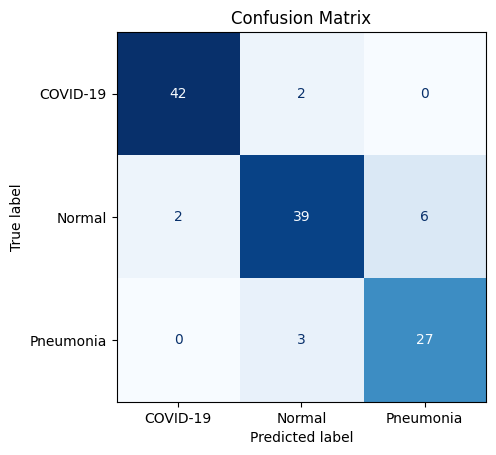

In [ ]:
from sklearn.linear_model import LogisticRegression

lr_flat = LogisticRegression(solver='lbfgs', random_state=RANDOM_STATE)

param_grid = {
    'C': [0.01, 0.1, 1, 10, 100],
    'max_iter': [100, 500, 1000]
}

grid_search = GridSearchCV(
    lr_flat,
    param_grid=param_grid,
    scoring='f1_macro',
    cv=5,
    n_jobs=-1, 
    verbose=0 
)

grid_search.fit(X_train_flat, y_train_flat)

print("Optimal Hyperparameters:")
print(grid_search.best_params_)

print(f"\nOptimal F1-macro score:: {grid_search.best_score_}")

# Set best estimator as model
lr_flat = grid_search.best_estimator_

# Get Results from Model
get_model_analytics(lr_flat, X_test_flat, y_test_flat)

### Random Forest on Flattened Images
We apply a Random Forest classifier with hyperparameter tuning via GridSearchCV. The optimal model is evaluated with a classification report and confusion matrix.

Optimal Hyperparameters:
{'max_depth': 5, 'max_features': 'sqrt', 'n_estimators': 75}

Optimal F1-macro score:: 0.8922569768973417
RANDOM FOREST CLASSIFIER MODEL ANALYTICS
--------------------------------------------------
ROC-AUC Scores with OVR:
                ROC-AUC

    COVID-19     0.9876
      Normal     0.9563
   Pneumonia     0.9425

   macro avg     0.9621


Classification Report:
              precision    recall  f1-score   support

    COVID-19     0.9268    0.8636    0.8941        44
      Normal     0.7627    0.9574    0.8491        47
   Pneumonia     0.9048    0.6333    0.7451        30

    accuracy                         0.8430       121
   macro avg     0.8648    0.8181    0.8294       121
weighted avg     0.8576    0.8430    0.8397       121



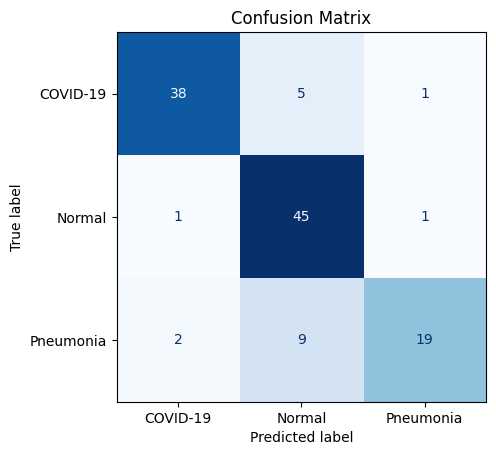

In [ ]:
from sklearn.ensemble import RandomForestClassifier

rf_flat = RandomForestClassifier(random_state=RANDOM_STATE)

param_grid = {
    'max_depth': range(5, 51, 5),
    'max_features': ['sqrt', 'log2'],
    'n_estimators': range(50, 151, 5)}

grid_search = GridSearchCV(
    rf_flat,
    param_grid=param_grid,
    cv=5,
    scoring='f1_macro',
    n_jobs=-1,
    verbose=0)

grid_search.fit(X_train_flat, y_train_flat)

print("Optimal Hyperparameters:")
print(grid_search.best_params_)

print(f"\nOptimal F1-macro score:: {grid_search.best_score_}")

# Set best estimator as model
rf_flat = grid_search.best_estimator_

# Get Results from Model
get_model_analytics(rf_flat, X_test_flat, y_test_flat)

### SVC on Flattened Images
An SVC classifier is trained with different kernels and hyperparameters to find the best fit for the flattened image data.

Optimal Hyperparameters:
{'C': 0.1, 'gamma': 1, 'kernel': 'linear'}

Optimal F1-macro score:: 0.878092466903375
SVC MODEL ANALYTICS
--------------------------------------------------
ROC-AUC Scores with OVR:
                ROC-AUC

    COVID-19     0.9944
      Normal     0.9638
   Pneumonia     0.9659

   macro avg     0.9747


Classification Report:
              precision    recall  f1-score   support

    COVID-19     0.9333    0.9545    0.9438        44
      Normal     0.8837    0.8085    0.8444        47
   Pneumonia     0.7879    0.8667    0.8254        30

    accuracy                         0.8760       121
   macro avg     0.8683    0.8766    0.8712       121
weighted avg     0.8780    0.8760    0.8759       121



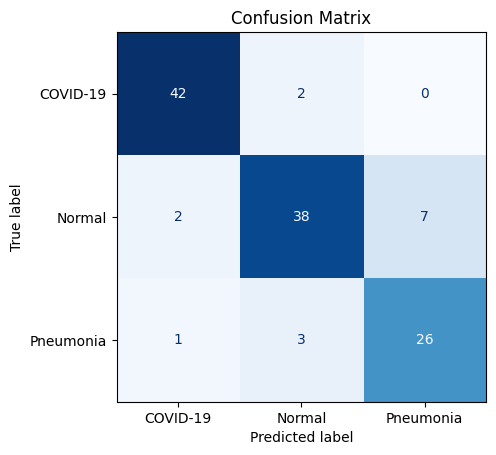

In [ ]:
from sklearn.svm import SVC

svc_flat = SVC(probability=True, random_state=RANDOM_STATE)

param_grid = {'C': [0.1, 1, 10, 100, 1000],  
              'gamma': [1, 0.1, 0.01, 0.001, 0.0001], 
              'kernel': ['linear', 'rbf']}

grid_search = GridSearchCV(
    svc_flat,
    param_grid=param_grid,
    cv=5,
    scoring='f1_macro',
    n_jobs=-1,
    verbose=0)

grid_search.fit(X_train_flat, y_train_flat)

print("Optimal Hyperparameters:")
print(grid_search.best_params_)

print(f"\nOptimal F1-macro score:: {grid_search.best_score_}")

# Set best estimator as model
svc_flat = grid_search.best_estimator_

# Get Results from Model
get_model_analytics(svc_flat, X_test_flat, y_test_flat)

### k-Nearest Neighbors on Flattened Images
We test the performance of a k-NN classifier by tuning the number of neighbors using grid search.

Optimal Hyperparameters:
{'n_neighbors': 12}

Optimal F1-macro score:: 0.819094607629761
K NEIGHBORS CLASSIFIER MODEL ANALYTICS
--------------------------------------------------
ROC-AUC Scores with OVR:
                ROC-AUC

    COVID-19     0.9951
      Normal     0.9130
   Pneumonia     0.9366

   macro avg     0.9483


Classification Report:
              precision    recall  f1-score   support

    COVID-19     0.9750    0.8864    0.9286        44
      Normal     0.7805    0.6809    0.7273        47
   Pneumonia     0.6250    0.8333    0.7143        30

    accuracy                         0.7934       121
   macro avg     0.7935    0.8002    0.7900       121
weighted avg     0.8127    0.7934    0.7973       121



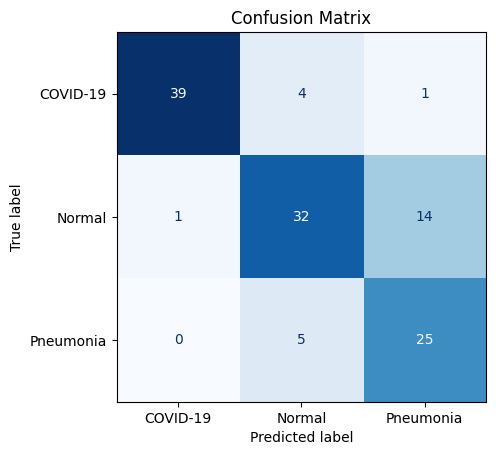

In [ ]:
from sklearn.neighbors import KNeighborsClassifier

knn_flat = KNeighborsClassifier()

param_grid = {'n_neighbors': range(1, 40)}

grid_search = GridSearchCV(
    knn_flat,
    param_grid=param_grid,
    cv=5,
    scoring='f1_macro',
    n_jobs=-1,
    verbose=0)

grid_search.fit(X_train_flat, y_train_flat)

print("Optimal Hyperparameters:")
print(grid_search.best_params_)

print(f"\nOptimal F1-macro score:: {grid_search.best_score_}")

# Set best estimator as model
knn_flat = grid_search.best_estimator_

# Get Results from Model
get_model_analytics(knn_flat, X_test_flat, y_test_flat)

# GLCM Section
## Texture-Based Feature Extraction
We extract GLCM (Gray-Level Co-occurrence Matrix) features from each image, which are effective for texture analysis in medical images. Features include contrast, energy, and correlation at multiple distances and angles.

In [18]:
def extract_glcm_features_df(images,
                            labels,
                            image_paths, 
                            target_size=(512, 512), 
                            distances=[1, 2, 3], 
                            angles=[0, np.pi/4, np.pi/2, 3*np.pi/4],
                            g_levels=256):
    """
    Extract GLCM features from images and organize into a DataFrame with image IDs and labels.
    
    Parameters:
    -----------
    images : list
        List of image arrays
    labels : list
        List of corresponding labels
    image_paths : list
        List of image file paths or IDs
    target_size : tuple
        Size to resize all images to (width, height)
    distances : list
        List of distances for GLCM calculation
    angles : list
        List of angles for GLCM calculation
    g_levels : int
        Number of gray levels to use for GLCM calculation (default is 256)

    Returns:
    --------
    df : pandas DataFrame
        DataFrame containing image_id, label, and all GLCM features
    """

    
    # GLCM properties to calculate
    properties = ['contrast', 'energy', 'correlation']
    
    # Create feature labels
    feature_labels = []
    for prop in properties:
        for d in distances:
            for a in angles:
                angle_deg = int(a * 180 / np.pi)  # Convert angle to degrees
                feature_labels.append(f"{prop}_d{d}_a{angle_deg}")
    
    # Initialize feature array
    n_features = len(properties) * len(distances) * len(angles)
    features = np.zeros((len(images), n_features))
    
    # Create image IDs from paths (get filename without extension)
    if isinstance(image_paths[0], str):
        image_ids = [os.path.splitext(os.path.basename(path))[0] for path in image_paths]
    else:
        # If not paths, use as is
        image_ids = image_paths
    
    # Extract GLCM features for each image
    for i, img in enumerate(images):
        if i % 100 == 0:
            print(f"Processing image {i}/{len(images)}")
        
        # Resize image to ensure consistency
        img_resized = resize(img, target_size, anti_aliasing=True, preserve_range=True).astype(np.uint8)
        
        # Rescale the image to have values between 0 and (levels-1)
        levels = g_levels
        # Normalization: Min-max scaling to range [0, levels-1]
        img_scaled = ((img_resized - img_resized.min()) / (img_resized.max() - img_resized.min() + 1e-10) * (levels-1)).astype(np.uint8)
        
        # Calculate GLCM
        glcm = graycomatrix(img_scaled, distances=distances, angles=angles, 
                           levels=levels, symmetric=True, normed=True)
        
        # Calculate GLCM properties
        feature_idx = 0
        for prop in properties:
            glcm_prop = graycoprops(glcm, prop)
            for d in range(len(distances)):
                for a in range(len(angles)):
                    features[i, feature_idx] = glcm_prop[d, a]
                    feature_idx += 1
    
    # Create the DataFrame
    data = {
        'image_id': image_ids,
        'label': labels
    }
    
    # Add each feature as a column
    for i, feature_name in enumerate(feature_labels):
        data[feature_name] = features[:, i]
    
    # Create the DataFrame
    df = pd.DataFrame(data)
    
    return glcm, df

In [19]:
glcm, glcm_df = extract_glcm_features_df(
    images, 
    labels, 
    image_paths, 
    target_size=(512, 512),
    distances=[1, 5, 10],
    angles=[0, np.pi/4, np.pi/2, 3*np.pi/4]
)

Processing image 0/603
Processing image 100/603
Processing image 200/603
Processing image 300/603
Processing image 400/603
Processing image 500/603
Processing image 600/603


### Train-Test Split on GLCM Data
We split the extracted GLCM features into training and testing sets for model evaluation.

In [39]:
X_train_glcm, X_test_glcm, y_train_glcm, y_test_glcm = train_test_split(
    glcm_df.drop(columns=['image_id', 'label'], axis=1),
    glcm_df['label'],
    test_size=0.3,
    random_state=RANDOM_STATE,
    stratify=glcm_df['label']
)

X_train_glcm = StandardScaler().fit_transform(X_train_glcm)
X_test_glcm = StandardScaler().fit_transform(X_test_glcm)

## Perform Machine Learning Techniques on GLCM Data

### Random Forest on GLCM Features
A Random Forest classifier is applied to the GLCM features, and performance is evaluated using classification metrics.

RANDOM FOREST CLASSIFIER MODEL ANALYTICS
--------------------------------------------------
ROC-AUC Scores with OVR:
                ROC-AUC

    COVID-19     0.9500
      Normal     0.9416
   Pneumonia     0.9480

   macro avg     0.9465


Classification Report:
              precision    recall  f1-score   support

    COVID-19     0.8261    0.8636    0.8444        66
      Normal     0.7922    0.8714    0.8299        70
   Pneumonia     0.8571    0.6667    0.7500        45

    accuracy                         0.8177       181
   macro avg     0.8251    0.8006    0.8081       181
weighted avg     0.8207    0.8177    0.8154       181



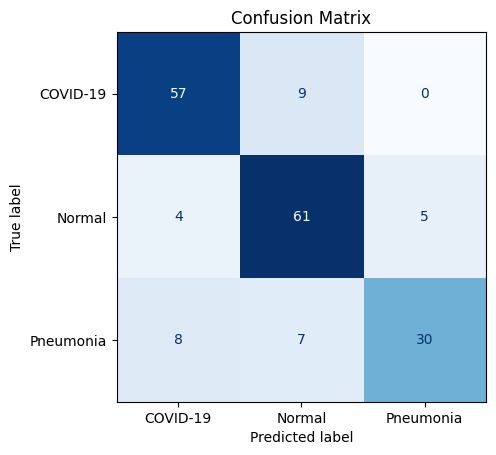

In [41]:
from sklearn.ensemble import RandomForestClassifier

rf_glcm = RandomForestClassifier(class_weight='balanced', random_state=RANDOM_STATE)

# Train the classifier
rf_glcm.fit(X_train_glcm, y_train_glcm)
# Get Results from Model
get_model_analytics(rf_glcm, X_test_glcm, y_test_glcm)

Optimal Hyperparameters:
{'max_depth': 10, 'max_features': 'sqrt', 'n_estimators': 120}

Optimal F1-macro score: 0.831952596360056
RANDOM FOREST CLASSIFIER MODEL ANALYTICS
--------------------------------------------------
ROC-AUC Scores with OVR:
                ROC-AUC

    COVID-19     1.0000
      Normal     1.0000
   Pneumonia     1.0000

   macro avg     1.0000


Classification Report:
              precision    recall  f1-score   support

    COVID-19     1.0000    1.0000    1.0000       155
      Normal     1.0000    1.0000    1.0000       164
   Pneumonia     1.0000    1.0000    1.0000       103

    accuracy                         1.0000       422
   macro avg     1.0000    1.0000    1.0000       422
weighted avg     1.0000    1.0000    1.0000       422



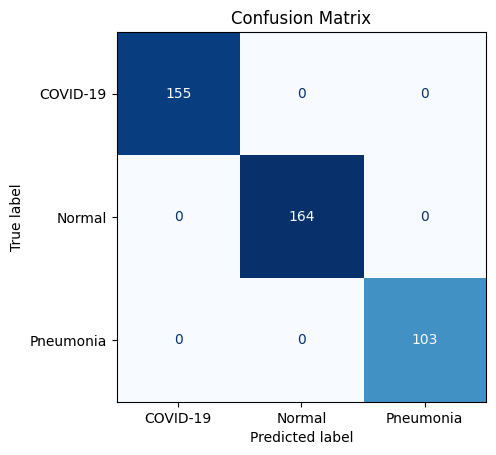

In [ ]:
param_grid = {
    'max_depth': range(5, 101, 5),
    'max_features': ['sqrt', 'log2'],
    'n_estimators': range(50, 301, 5)
}

grid_search = GridSearchCV(
    rf_glcm, 
    param_grid=param_grid,
    cv=5, 
    scoring='f1_macro',
    n_jobs=-1
)

grid_search.fit(X_train_glcm, y_train_glcm)

print("Optimal Hyperparameters:")
print(grid_search.best_params_)

print(f"\nOptimal F1-macro score: {grid_search.best_score_}")

# Set best estimator as model
rf_glcm = grid_search.best_estimator_
# Get Results from Model
get_model_analytics(rf_glcm, X_test_glcm, y_test_glcm)

### SVM on GLCM Features
We train a linear Support Vector Machine (SVM) on the GLCM features and evaluate its classification performance.

SVC MODEL ANALYTICS
--------------------------------------------------
ROC-AUC Scores with OVR:
                ROC-AUC

    COVID-19     0.9737
      Normal     0.9631
   Pneumonia     0.9289

   macro avg     0.9553


Classification Report:
              precision    recall  f1-score   support

    COVID-19     0.9262    0.8903    0.9079       155
      Normal     0.8380    0.9146    0.8746       164
   Pneumonia     0.7872    0.7184    0.7513       103

    accuracy                         0.8578       422
   macro avg     0.8505    0.8411    0.8446       422
weighted avg     0.8580    0.8578    0.8567       422



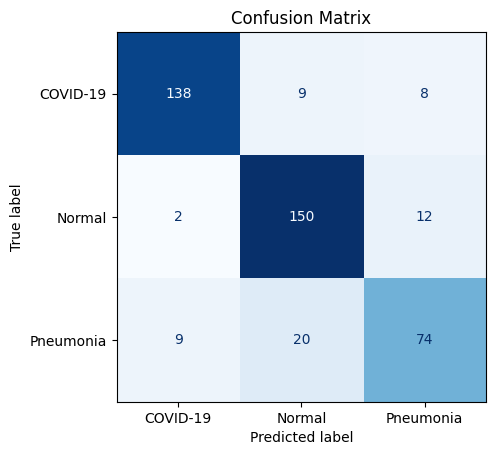

In [43]:
from sklearn.svm import SVC

svc_glcm = SVC(probability=True, random_state=RANDOM_STATE)

# Train the classifier
svc_glcm.fit(X_train_glcm, y_train_glcm)
# Get Results from Model
get_model_analytics(svc_glcm, X_train_glcm, y_train_glcm)

In [44]:
# param_grid = {
#     'kernel': ['linear', 'poly', 'rbf', 'sigmoid'],
#     'C': np.logspace(-3, 3, 7),
#     'gamma': np.logspace(-3, 3, 7),
#     'degree': [2, 3, 4]
# }

# svm_gridsearch = GridSearchCV(
#     SVC(probability=True),
#     param_grid,
#     cv=5,
#     scoring='f1_macro',
#     n_jobs=-1,
#     verbose=1
# )


# svm_gridsearch.fit(X= X_train, y= y_train)

In [45]:
# best_params = svm_gridsearch.best_params_
# print(f"Best parameters: {best_params}")
# best_svm = SVC(**best_params)

In [46]:
# best_svm.fit(X_train, y_train)
# get_model_analytics(best_svm, X_train, y_train)

In [47]:
# # Finer grid search around best values
# fine_param_grid = {
#     'C': np.logspace(2, 4, 10),  # Values between 100 and 10000
#     'gamma': np.logspace(-4, -2, 10),  # Values around 0.001
#     'kernel': ['rbf'],
#     'class_weight': [None, 'balanced']  # Try with class weighting
# }

# fine_svm_gridsearch = GridSearchCV(
#     SVC(probability=True),
#     fine_param_grid,
#     cv=5,
#     scoring='f1_macro',
#     n_jobs=-1,
#     verbose=1
# )

# fine_svm_gridsearch.fit(X_train, y_train)

In [48]:
# best_params = fine_svm_gridsearch.best_params_
# print(f"Best parameters: {best_params}")
# best_svm = SVC(**best_params)

In [49]:
# best_svm.fit(X_train, y_train)
# get_model_analytics(best_svm, X_train, y_train)

### k-Nearest Neighbors on GLCM Features
k-NN is tested again, this time using the texture-based features extracted from GLCM.

K NEIGHBORS CLASSIFIER MODEL ANALYTICS
--------------------------------------------------
ROC-AUC Scores with OVR:
                ROC-AUC

    COVID-19     0.9764
      Normal     0.9709
   Pneumonia     0.9356

   macro avg     0.9610


Classification Report:
              precision    recall  f1-score   support

    COVID-19     0.9197    0.8129    0.8630       155
      Normal     0.8427    0.9146    0.8772       164
   Pneumonia     0.7383    0.7670    0.7524       103

    accuracy                         0.8412       422
   macro avg     0.8336    0.8315    0.8309       422
weighted avg     0.8455    0.8412    0.8415       422



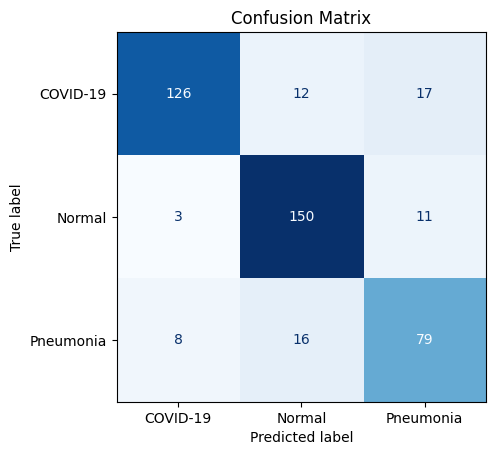

In [50]:
from sklearn.neighbors import KNeighborsClassifier

knn_glcm = KNeighborsClassifier(n_neighbors=5)

# Train the classifier
knn_glcm.fit(X_train_glcm, y_train_glcm)
# Get Results from Model
get_model_analytics(knn_glcm, X_train_glcm, y_train_glcm)

Fitting 5 folds for each of 30 candidates, totalling 150 fits
Optimal Hyperparameters:
{'metric': 'chebyshev', 'n_neighbors': 9, 'weights': 'uniform'}

Optimal F1-macro score: 0.7900995161856117
K NEIGHBORS CLASSIFIER MODEL ANALYTICS
--------------------------------------------------
ROC-AUC Scores with OVR:
                ROC-AUC

    COVID-19     0.9530
      Normal     0.9600
   Pneumonia     0.9274

   macro avg     0.9468


Classification Report:
              precision    recall  f1-score   support

    COVID-19     0.9322    0.8333    0.8800        66
      Normal     0.8312    0.9143    0.8707        70
   Pneumonia     0.7556    0.7556    0.7556        45

    accuracy                         0.8453       181
   macro avg     0.8396    0.8344    0.8354       181
weighted avg     0.8492    0.8453    0.8455       181



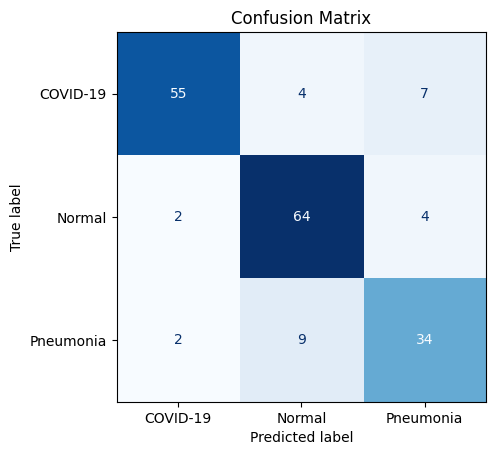

In [51]:
param_grid = {
    'n_neighbors': [3, 5, 7, 9, 11],
    'weights': ['uniform', 'distance'],
    'metric': ['euclidean', 'manhattan', 'chebyshev']
}
grid_search = GridSearchCV(
    knn_glcm, 
    param_grid=param_grid, 
    cv=5, 
    scoring='f1_macro', 
    n_jobs=-1, 
    verbose=1
)

grid_search.fit(X_train_glcm, y_train_glcm)

# Print the best hyperparameters and the corresponding score
print("Optimal Hyperparameters:")
print(grid_search.best_params_)

print(f"\nOptimal F1-macro score: {grid_search.best_score_}")

# Use the best model from the grid search
knn_glcm = grid_search.best_estimator_

# Get Results from the optimized model
get_model_analytics(knn_glcm, X_test_glcm, y_test_glcm)

### Logistic Regression on GLCM Features
Logistic regression is applied with L1 and L2 regularization to classify the GLCM features.

LOGISTIC REGRESSION MODEL ANALYTICS
--------------------------------------------------
ROC-AUC Scores with OVR:
                ROC-AUC

    COVID-19     0.9781
      Normal     0.9662
   Pneumonia     0.9464

   macro avg     0.9636


Classification Report:
              precision    recall  f1-score   support

    COVID-19     0.9281    0.9161    0.9221       155
      Normal     0.8727    0.8780    0.8754       164
   Pneumonia     0.7981    0.8058    0.8019       103

    accuracy                         0.8744       422
   macro avg     0.8663    0.8667    0.8665       422
weighted avg     0.8748    0.8744    0.8746       422



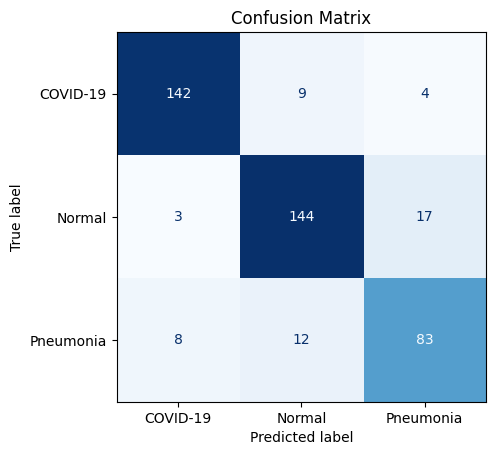

In [52]:
from sklearn.linear_model import LogisticRegression

lr_glcm = LogisticRegression(solver='lbfgs', random_state=RANDOM_STATE)

# Train the classifier
lr_glcm.fit(X_train_glcm, y_train_glcm)
# Get Results from Model
get_model_analytics(lr_glcm, X_train_glcm, y_train_glcm)

Optimal Hyperparameters:
{'C': 100, 'max_iter': 100}

Optimal F1-macro score: 0.8555011376401392
LOGISTIC REGRESSION MODEL ANALYTICS
--------------------------------------------------
ROC-AUC Scores with OVR:
                ROC-AUC

    COVID-19     0.9943
      Normal     0.9784
   Pneumonia     0.9718

   macro avg     0.9815


Classification Report:
              precision    recall  f1-score   support

    COVID-19     0.9477    0.9355    0.9416       155
      Normal     0.9018    0.8963    0.8991       164
   Pneumonia     0.8113    0.8350    0.8230       103

    accuracy                         0.8957       422
   macro avg     0.8870    0.8889    0.8879       422
weighted avg     0.8966    0.8957    0.8961       422



lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


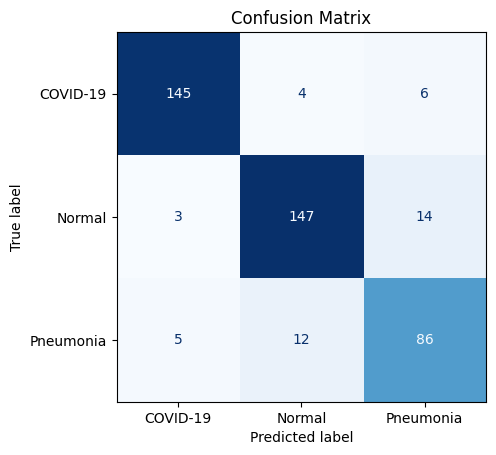

In [53]:
param_grid = {
    'C': [0.01, 0.1, 1, 10, 100],
    'max_iter': [100, 500, 1000]
}

grid_search = GridSearchCV(
    lr_glcm, 
    param_grid=param_grid,
    cv=5, 
    scoring='f1_macro',
    n_jobs=-1
)

grid_search.fit(X_train_glcm, y_train_glcm)

print("Optimal Hyperparameters:")
print(grid_search.best_params_)

print(f"\nOptimal F1-macro score: {grid_search.best_score_}")

# Set best estimator as model
lr_glcm = grid_search.best_estimator_
# Get Results from Model
get_model_analytics(lr_glcm, X_train_glcm, y_train_glcm)

# Results

In [54]:
output_columns = []  # reset before starting

# First row of data
run_model_analytics_in_column(lr_flat, X_test_flat, y_test_flat, output_columns)
run_model_analytics_in_column(rf_flat, X_test_flat, y_test_flat, output_columns)
run_model_analytics_in_column(knn_flat, X_test_flat, y_test_flat, output_columns)
run_model_analytics_in_column(svc_flat, X_test_flat, y_test_flat, output_columns)
# Second row of data
run_model_analytics_in_column(lr_glcm, X_test_glcm, y_test_glcm, output_columns)
run_model_analytics_in_column(rf_glcm, X_test_glcm, y_test_glcm, output_columns)
run_model_analytics_in_column(knn_glcm, X_test_glcm, y_test_glcm, output_columns)
run_model_analytics_in_column(svc_glcm, X_test_glcm, y_test_glcm, output_columns)

show_model_analytics_columns(output_columns)
